## 파일 불러오기

예시로 `records_sample.pkl` 을 불러왔으나, 만약 본인이 측정한 record 파일이 있다면 그걸로 대체 가능

In [1]:
import time, pickle
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from pynput.mouse import Listener


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF, WhiteKernel, DotProduct, ConstantKernel

records = pickle.load(open('records_sample.pkl', 'rb'))

In [2]:
X = [ r['landmark'] for r in records ]
X = np.array(X).reshape(-1, 478*3)
y = [ r['coord'] for r in records ]
y = np.array(y)

print(X.shape, y.shape)

(75, 1434) (75, 2)


## 회귀분석 및 정확도 확인

In [3]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.15)
#model = LinearRegression()
model = GaussianProcessRegressor(kernel=RationalQuadratic())
model.fit(train_X, train_y)

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1))

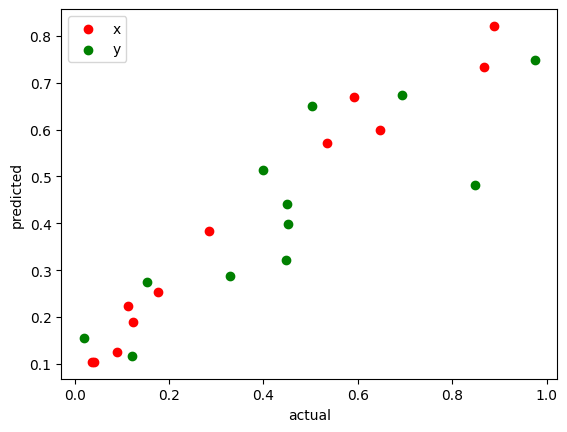

오차범위 : 12.05%


In [4]:
pred_y = model.predict(test_X)
plt.scatter(test_y[:,0], pred_y[:,0], c='r')
plt.scatter(test_y[:,1], pred_y[:,1], c='g')
plt.legend(['x', 'y'])
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

err = np.sqrt(((test_y - pred_y)**2).mean())
print(f'오차범위 : {err*100:.2f}%')

## 여러 모델에 대해서 100번씩 실험하여, 가장 우수한 모델 선정

In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# ConvergenceWarning을 무시하도록 설정
warnings.simplefilter("ignore", ConvergenceWarning)
import warnings
from sklearn.exceptions import ConvergenceWarning

# ConvergenceWarning을 무시하도록 설정
warnings.simplefilter("ignore", ConvergenceWarning)

kernels = [RationalQuadratic(), RBF(), WhiteKernel(), DotProduct()]
for kernel in kernels:
    model = GaussianProcessRegressor(kernel=kernel)
    errs = []
    for i in range(100):
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.15)
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        errs.append(np.sqrt(((test_y - pred_y)**2).mean()))
    print(f'{kernel} : {np.mean(errs)*100:.2f}%')

errs = []
model = LinearRegression()
for i in range(100):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.15)
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    errs.append(np.sqrt(((test_y - pred_y)**2).mean()))
print(f'LinearRegression : {np.mean(errs)*100:.2f}%')

RationalQuadratic(alpha=1, length_scale=1) : 10.52%
RBF(length_scale=1) : 17.77%
WhiteKernel(noise_level=1) : 46.42%
DotProduct(sigma_0=1) : 12.36%
LinearRegression : 12.41%


결론적으로 RationaleQuadratic kernel 을 사용하는 것이 성능이 가장 좋다.

## 실시간 시선 예측

In [6]:
def predict_landmark(landmark):
    # landmark를 입력받아 모델의 예측을 반환하는 함수
    X = np.array([ [d.x, d.y, d.z] for d in landmark ])
    X = X.reshape(1, 478*3)
    return model.predict(X)[0]

def predict_landmark_smooth(landmark):
    # moving average를 적용하여 노이즈를 줄이는 버전의 함수
    if len(coords_traj) > 0:
        prev = coords_traj[-1]
        curr = predict_landmark(landmark)
        curr = prev*0.8 + curr*0.2
    else:
        curr = predict_landmark(landmark)
    return curr

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
model = GaussianProcessRegressor(kernel=RationalQuadratic())
model.fit(X, y)

# 웹캠 화면이 최상단에 뜨게 하기 위한 설정
# 최상단을 유지하려는 경우에만 주석을 해제해주세요
# cv2.namedWindow('window', cv2.WINDOW_AUTOSIZE)
# cv2.setWindowProperty('window', cv2.WND_PROP_TOPMOST, 1)

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1))

In [7]:
coords_traj = []

with mp_face_mesh.FaceMesh(
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("웹캠을 찾을 수 없습니다.")
            break

        image.flags.writeable = False # 성능 향상을 위해 이미지를 읽기 전용으로 만듭니다.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                mp_drawing.draw_landmarks(
                    image=image,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles
                    .get_default_face_mesh_tesselation_style())
                mp_drawing.draw_landmarks(
                    image=image,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles
                    .get_default_face_mesh_contours_style())
                mp_drawing.draw_landmarks(
                    image=image,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_IRISES,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles
                    .get_default_face_mesh_iris_connections_style())
                
            image = cv2.flip(image, 1)
            coord = predict_landmark_smooth(face_landmarks.landmark)
            coords_traj.append(coord)
            cv2.putText(image, f'x: {coord[0]:.2f}, y: {coord[1]:.2f}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow('window', image)
        # 이미지 재생을 위한 대기시간
        cv2.waitKey(5)
        
cap.release()

KeyboardInterrupt: 

## 시선 궤적 시각화

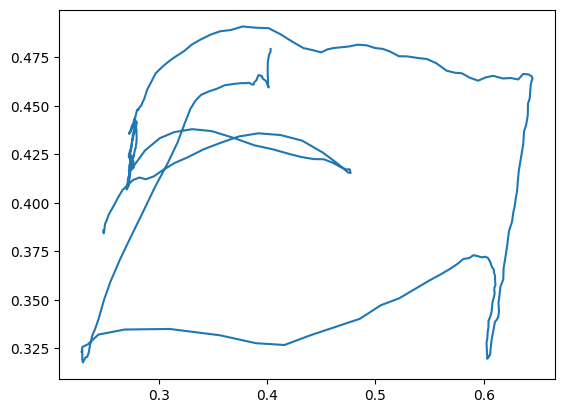

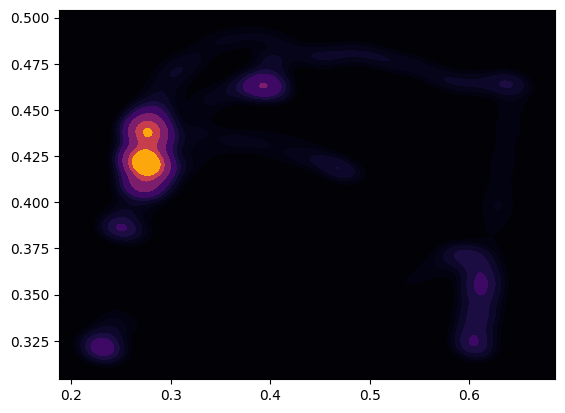

In [8]:
coords_traj = np.array(coords_traj)
plt.plot(coords_traj[:,0], coords_traj[:,1])
plt.show()

#2d kde
sns.kdeplot(x=coords_traj[:,0], y=coords_traj[:,1], bw_method=0.1,cmap='inferno', fill=True, thresh=0)
plt.show()
